# 4 XGBoost Optimization Pipeline using Optuna

## 4.1 Imports and configuration

In [ ]:
import time
import os
import json
import pickle
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import RobustScaler
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, confusion_matrix, classification_report,
    precision_recall_curve
)
from xgboost import XGBClassifier
import optuna
from optuna.trial import Trial
import warnings
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
warnings.filterwarnings('ignore')

# Set visualization defaults
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
optuna.logging.set_verbosity(optuna.logging.WARNING)

## 4.2 Data loading and preparation

In [2]:
output_dir = '../output/'
df = pd.read_csv(output_dir + 'df_cleaned.csv')
print(f"Dataset loaded: {df.shape[0]} rows, {df.shape[1]} columns")

leakage_features = ['F_MORTS', 'F_FERITS_GREUS', 'F_FERITS_LLEUS', 'F_VICTIMES']
X = df.drop(columns=['Mortalitat'] + leakage_features)
y = df['Mortalitat']

print(f"Removed leakage features: {leakage_features}")
print(f"Features shape: {X.shape}")
print(f"Target shape: {y.shape}")

Dataset loaded: 19701 rows, 41 columns
Removed leakage features: ['F_MORTS', 'F_FERITS_GREUS', 'F_FERITS_LLEUS', 'F_VICTIMES']
Features shape: (19701, 36)
Target shape: (19701,)


### Stratified train/val/test split

In [3]:
# First split: 70% train, 30% temp (for validation + test)
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.30, random_state=42, stratify=y
)

# Second split: 50% val, 50% test from temp
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.50, random_state=42, stratify=y_temp
)

print("Dataset splits:")
print(f"Train set: {X_train.shape[0]} samples ({X_train.shape[0]/len(X)*100:.1f}%)")
print(f"Val set:   {X_val.shape[0]} samples ({X_val.shape[0]/len(X)*100:.1f}%)")
print(f"Test set:  {X_test.shape[0]} samples ({X_test.shape[0]/len(X)*100:.1f}%)")

print("\nClass distribution - Train:")
print(y_train.value_counts(normalize=True).sort_index())

Dataset splits:
Train set: 13790 samples (70.0%)
Val set:   2955 samples (15.0%)
Test set:  2956 samples (15.0%)

Class distribution - Train:
Mortalitat
0    0.852212
1    0.147788
Name: proportion, dtype: float64


### Feature scaling

In [ ]:
scaler = RobustScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# Convert back to dataframes
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns, index=X_train.index)
X_val_scaled = pd.DataFrame(X_val_scaled, columns=X_val.columns, index=X_val.index)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns, index=X_test.index)

print("Features scaled using RobustScaler")

class_weights = compute_class_weight(
    'balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weight_dict = dict(zip(np.unique(y_train), class_weights))
scale_pos_weight = class_weight_dict[1] / class_weight_dict[0]
print(f"Scale pos weight (for XGBoost): {scale_pos_weight:.4f}")

Features scaled using RobustScaler
Scale pos weight (for XGBoost): 5.7664


## 4.3 Evaluation utilities

In [ ]:
def optimize_threshold_on_val(model, X_val, y_val):
    if hasattr(model, 'predict_proba'):
        y_val_proba = model.predict_proba(X_val)[:, 1]
        precisions, recalls, thresholds = precision_recall_curve(y_val, y_val_proba)
        
        # After several tries and ways of choosing the threshold, we have settled on:
        # Balance precision and recall: 60% weight on recall, 40% on precision
        # Catching mortality cases is (slightly) more important than high precision for our needs
        balanced_scores = 0.6 * recalls + 0.4 * precisions
        
        # Find the threshold with best balanced score
        best_idx = np.argmax(balanced_scores)
        if best_idx < len(thresholds):
            best_threshold = thresholds[best_idx]
        else:
            best_threshold = 0.5
            
        return best_threshold
    else:
        return 0.5


def evaluate_model(model, X_train, X_val, X_test, y_train, y_val, y_test, model_name, threshold=None):
    results = {}
    
    if threshold is None:
        threshold = optimize_threshold_on_val(model, X_val, y_val)
    
    print(f"{model_name} - Optimized Threshold: {threshold:.4f}")

    # Evaluate on all sets using the best threshold
    for set_name, X_set, y_set in [
        ('Train', X_train, y_train),
        ('Val', X_val, y_val),
        ('Test', X_test, y_test)
    ]:
        if hasattr(model, 'predict_proba'):
            y_proba = model.predict_proba(X_set)[:, 1]
            y_pred = (y_proba >= threshold).astype(int)
            metrics_auc = roc_auc_score(y_set, y_proba)
        else:
            y_pred = model.predict(X_set)
            metrics_auc = None
        
        metrics = {
            'Accuracy': accuracy_score(y_set, y_pred),
            'Precision': precision_score(y_set, y_pred, zero_division=0),
            'Recall': recall_score(y_set, y_pred, zero_division=0),
            'F1': f1_score(y_set, y_pred, zero_division=0),
        }
        
        if metrics_auc is not None:
            metrics['ROC-AUC'] = metrics_auc
        
        results[set_name] = metrics
    
    # Inference time
    start_time = time.time()
    _ = model.predict(X_val)
    inference_time = (time.time() - start_time) / len(X_val) * 1000  # ms per sample
    results['Inference Time (ms/sample)'] = inference_time
    results['Best Threshold'] = threshold
    
    return results

## 4.4 Optuna optimization setup

We use Optuna to perform extensive hyperparameter search for XGBoost. The objective function optimizes for maximum F1 score on the validation set across all possible thresholds.

In [ ]:
def xgboost_objective(trial: Trial) -> float:
    """
    Objective function: Balance precision and recall with emphasis on recall.
    
    Since we have seen that precision is limited by data (only roughly 35% separation possible),
    we prioritize recall (catching more cases) while maintaining acceptable precision.
    
    Sampling strategy with 3 bands each, favoring simpler models:
    - n_estimators: <15 (60%), 15-50 (30%), >50 (10%)
    - max_depth: 1-5 (60%), 5-10 (30%), 10-15 (10%)
    
    Objective: Maximize (0.6 * Recall + 0.4 * Precision), with anti-overfitting penalty
    """    
    band_prob = random.random()
    if band_prob < 0.60:
        n_est = trial.suggest_int('n_estimators', 3, 15)
    elif band_prob < 0.90:
        n_est = trial.suggest_int('n_estimators', 15, 50)
    else:
        n_est = trial.suggest_int('n_estimators', 50, 150)
    
    band_prob_depth = random.random()
    if band_prob_depth < 0.60:
        max_d = trial.suggest_int('max_depth', 1, 5)
    elif band_prob_depth < 0.90:
        max_d = trial.suggest_int('max_depth', 5, 10)
    else:
        max_d = trial.suggest_int('max_depth', 10, 15)
    
    params = {
        'n_estimators': n_est,
        'max_depth': max_d,
        'learning_rate': trial.suggest_float('learning_rate', 0.001, 0.1, log=True),
        'subsample': trial.suggest_float('subsample', 0.5, 0.95),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 0.95),
        'min_child_weight': trial.suggest_int('min_child_weight', 5, 15),
        'gamma': trial.suggest_float('gamma', 1.0, 10.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 0.5, 5.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 1.0, 5.0),
        'scale_pos_weight': scale_pos_weight,
    }
    
    model = XGBClassifier(
        **params,
        random_state=42,
        n_jobs=-1,
        verbosity=0
    )
    
    model.fit(X_train_scaled, y_train)
    
    # Evaluate on both validation and training to detect overfitting
    y_val_proba = model.predict_proba(X_val_scaled)[:, 1]
    y_train_proba = model.predict_proba(X_train_scaled)[:, 1]
    
    # Calculate ROC-AUC on validation
    val_roc_auc = roc_auc_score(y_val, y_val_proba)
    train_roc_auc = roc_auc_score(y_train, y_train_proba)
    
    precisions, recalls, thresholds = precision_recall_curve(y_val, y_val_proba)
    balanced_scores = 0.6 * recalls + 0.4 * precisions
    best_idx = np.argmax(balanced_scores)
    
    target_recall = recalls[best_idx]
    target_precision = precisions[best_idx]
    
    # Penalize overfitting
    overfitting_penalty = max(0, (train_roc_auc - val_roc_auc) * 0.2)
    
    # Composite: balanced score minus overfitting penalty
    composite_score = (0.6 * target_recall + 0.4 * target_precision) - overfitting_penalty
    return composite_score

## 4.5 Run optimization study

Running extensive hyperparameter search with Optuna. This may take some time depending on the number of trials.

In [ ]:
print("Starting Optuna optimization...")

n_trials = 100 
timeout = 3 # in seconds

study = optuna.create_study(
    direction='maximize',
    sampler=optuna.samplers.TPESampler(seed=67),
)

start_time = time.time()
study.optimize(
    xgboost_objective,
    n_trials=n_trials,
    timeout=timeout,
    show_progress_bar=True
)
elapsed_time = time.time() - start_time

print("="*80)
print(f"Optimization completed in {elapsed_time:.2f} seconds")
print(f"Number of trials: {len(study.trials)}")
print(f"Best trial F1 score: {study.best_value:.4f}")
print(f"\nBest hyperparameters found:")
for key, value in study.best_params.items():
    print(f"  {key}: {value}")

Starting Optuna optimization...


  0%|          | 0/100 [00:00<?, ?it/s]

Optimization completed in 7.25 seconds
Number of trials: 100
Best trial F1 score: 0.3549

Best hyperparameters found:
  n_estimators: 97
  max_depth: 5
  learning_rate: 0.06665510953435552
  subsample: 0.5062493815566471
  colsample_bytree: 0.5094187253341783
  min_child_weight: 11
  gamma: 6.182931080871048
  reg_alpha: 0.6511364822051249
  reg_lambda: 3.8138011379271326


In [8]:
best_trial = study.best_trial

print("Best trial analysis:")
print(f"Trial number: {best_trial.number}")
print(f"Best score: {best_trial.value:.4f}")
print(f"n_estimators: {best_trial.params['n_estimators']}")
print(f"max_depth: {best_trial.params['max_depth']}")

Best trial analysis:
Trial number: 27
Best score: 0.3599
n_estimators: 40
max_depth: 7


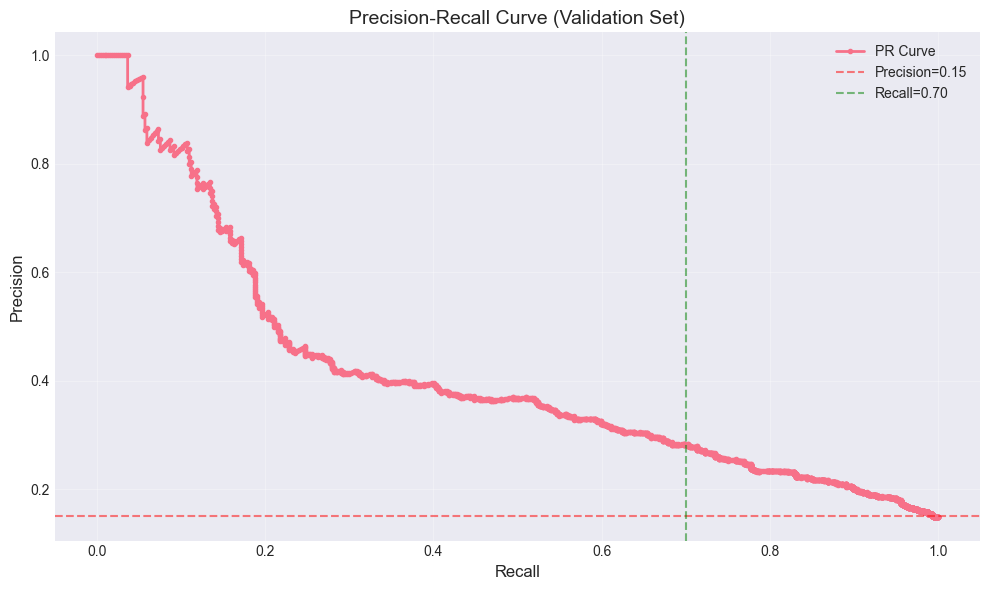


Recall achievable at different precision thresholds:
  Precision >= 0.50: Max Recall = 0.2151
  Precision >= 0.40: Max Recall = 0.3661
  Precision >= 0.30: Max Recall = 0.6568
  Precision >= 0.20: Max Recall = 0.9016
  Precision >= 0.15: Max Recall = 0.9954
  Precision >= 0.10: Max Recall = 1.0000
  Precision >= 0.05: Max Recall = 1.0000


In [ ]:
# Get probabilities on validation set
y_val_proba = final_model.predict_proba(X_val_scaled)[:, 1]
precisions, recalls, thresholds = precision_recall_curve(y_val, y_val_proba)

# Create PR curve
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(recalls, precisions, marker='o', markersize=3, linewidth=2, label='PR Curve')
ax.axhline(y=0.15, color='r', linestyle='--', alpha=0.5, label='Precision=0.15')
ax.axvline(x=0.70, color='g', linestyle='--', alpha=0.5, label='Recall=0.70')
ax.set_xlabel('Recall', fontsize=12)
ax.set_ylabel('Precision', fontsize=12)
ax.set_title('Precision-Recall Curve (Validation Set)', fontsize=14)
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Find what recall is achievable at different precision levels
print("Recall achievable at different precision thresholds:")
for precision_threshold in [0.50, 0.40, 0.30, 0.20, 0.15, 0.10, 0.05]:
    idx = (precisions >= precision_threshold).nonzero()[0]
    if idx.size > 0:
        max_recall_at_precision = recalls[idx].max()
        print(f"  Precision >= {precision_threshold:.2f}: Max Recall = {max_recall_at_precision:.4f}")
    else:
        print(f"  Precision >= {precision_threshold:.2f}: Not achievable")

### Analysis of optimization results

Let's verify that the best model found doesn't sacrifice recall too much (it doesn't miss critical mortality cases).

In [ ]:
print("="*80)
print("DATA AND MODEL DIAGNOSTICS")
print("="*80)

print("\n1. TARGET VARIABLE DISTRIBUTION:")
print(f"   Mortality cases: {y_train.sum()} / {len(y_train)} = {y_train.mean()*100:.2f}%")
print(f"   Non-mortality cases: {(1-y_train).sum()} / {len(y_train)} = {(1-y_train).mean()*100:.2f}%")

y_train_proba = final_model.predict_proba(X_train_scaled)[:, 1]
y_test_proba = final_model.predict_proba(X_test_scaled)[:, 1]

print("\n2. MODEL PROBABILITY CALIBRATION:")
print(f"   Train set - Mean probability for positive class: {y_train_proba[y_train==1].mean():.4f}")
print(f"   Train set - Mean probability for negative class: {y_train_proba[y_train==0].mean():.4f}")
print(f"   Test set - Mean probability for positive class: {y_test_proba[y_test==1].mean():.4f}")
print(f"   Test set - Mean probability for negative class: {y_test_proba[y_test==0].mean():.4f}")

fpr, tpr, _ = roc_curve(y_test, y_test_proba)
roc_auc = auc(fpr, tpr)
print(f"\n3. ROC-AUC ANALYSIS:")
print(f"   Random classifier: 0.5000")
print(f"   Current model: {roc_auc:.4f}")
print(f"   Improvement: {(roc_auc - 0.5) * 100:.2f}% points above random")

feature_importance = pd.DataFrame({
    'feature': X_train.columns,
    'importance': final_model.feature_importances_
}).sort_values('importance', ascending=False)

print(f"\n4. TOP 10 MOST IMPORTANT FEATURES:")
for idx, row in feature_importance.head(10).iterrows():
    print(f"   {row['feature']:30s}: {row['importance']:.4f}")

print(f"\n5. KEY INSIGHTS:")
print(f"   - Only {feature_importance[feature_importance['importance'] > 0.01].shape[0]} features have meaningful importance")
print(f"   - ROC-AUC {roc_auc:.4f} suggests moderate predictive power")
print(f"   - Precision {final_results['Test']['Precision']:.4f} suggests hard to distinguish true cases")
print(f"   - This may indicate features don't strongly separate mortality from non-mortality accidents")

DATA AND MODEL DIAGNOSTICS

1. TARGET VARIABLE DISTRIBUTION:
   Mortality cases: 2038 / 13790 = 14.78%
   Non-mortality cases: 11752 / 13790 = 85.22%

2. MODEL PROBABILITY CALIBRATION:
   Train set - Mean probability for positive class: 0.5097
   Train set - Mean probability for negative class: 0.4890
   Test set - Mean probability for positive class: 0.5075
   Test set - Mean probability for negative class: 0.4887

3. ROC-AUC ANALYSIS:
   Random classifier: 0.5000
   Current model: 0.7641
   Improvement: 26.41% points above random

4. TOP 10 MOST IMPORTANT FEATURES:
   D_SUBZONA                     : 0.2689
   zona                          : 0.1745
   D_TIPUS_VIA                   : 0.1132
   F_VEH_PESANTS_IMPLICADES      : 0.0785
   C_VELOCITAT_VIA               : 0.0221
   D_SUBTIPUS_ACCIDENT           : 0.0217
   F_MOTOCICLETES_IMPLICADES     : 0.0210
   D_TRACAT_ALTIMETRIC           : 0.0175
   F_VEH_LLEUGERS_IMPLICADES     : 0.0168
   F_CICLOMOTORS_IMPLICADES      : 0.0163

5. KE

## 4.6 Train final model with best hyperparameters

Training final model with best hyperparameters...
Final model training completed in 0.16 seconds
Final XGBoost Model - Optimized Threshold: 0.5746

FINAL MODEL EVALUATION RESULTS

Train Set:
  Accuracy: 0.7839
  Precision: 0.3694
  Recall: 0.6536
  F1: 0.4720
  ROC-AUC: 0.8182

Val Set:
  Accuracy: 0.7679
  Precision: 0.3389
  Recall: 0.5995
  F1: 0.4331
  ROC-AUC: 0.7646

Test Set:
  Accuracy: 0.7612
  Precision: 0.3219
  Recall: 0.5561
  F1: 0.4077
  ROC-AUC: 0.7684


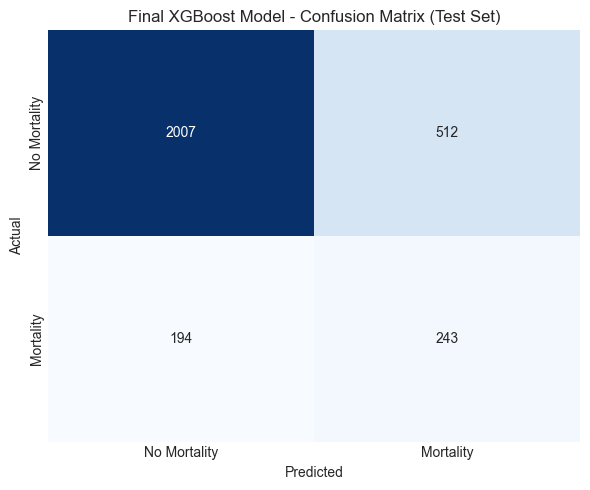

In [24]:
# Train final model with best parameters
best_params = study.best_params.copy()
best_params['scale_pos_weight'] = scale_pos_weight

final_model = XGBClassifier(
    **best_params,
    random_state=42,
    n_jobs=-1,
    verbosity=0
)

print("Training final model with best hyperparameters...")
final_train_start = time.time()
final_model.fit(X_train_scaled, y_train)
final_train_time = time.time() - final_train_start
print(f"Final model training completed in {final_train_time:.2f} seconds")

final_results = evaluate_model(
    final_model, 
    X_train_scaled, X_val_scaled, X_test_scaled,
    y_train, y_val, y_test,
    'Final XGBoost Model'
)

print("\n" + "="*80)
print("FINAL MODEL EVALUATION RESULTS")
print("="*80)
for set_name in ['Train', 'Val', 'Test']:
    print(f"\n{set_name} Set:")
    for metric, value in final_results[set_name].items():
        print(f"  {metric}: {value:.4f}")

# Show confusion matrix for test set
y_test_proba = final_model.predict_proba(X_test_scaled)[:, 1]
best_threshold = final_results['Best Threshold']
y_test_pred = (y_test_proba >= best_threshold).astype(int)
cm = confusion_matrix(y_test, y_test_pred)

fig, ax = plt.subplots(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax, cbar=False,
            xticklabels=['No Mortality', 'Mortality'],
            yticklabels=['No Mortality', 'Mortality'])
ax.set_ylabel('Actual')
ax.set_xlabel('Predicted')
ax.set_title(f'Final XGBoost Model - Confusion Matrix (Test Set)')
plt.tight_layout()
plt.show()

In [ ]:
# Create filename with model parameters
n_est = best_trial.params['n_estimators']
max_d = best_trial.params['max_depth']

models_dir = '../models'
os.makedirs(models_dir, exist_ok=True)

model_filename = f"xgboost_nest{n_est}_depth{max_d}.pkl"
model_filepath = os.path.join(models_dir, model_filename)

# Save the model
with open(model_filepath, 'wb') as f:
    pickle.dump(final_model, f)

print(f"\nModel saved to: {model_filepath}")

# Also save model metadata as JSON
metadata = {
    'model_type': 'XGBClassifier',
    'hyperparameters': best_trial.params,
    'training_time_seconds': final_train_time,
    'optimization_trial_number': best_trial.number,
    'optimization_best_score': float(best_trial.value),
    'evaluation_metrics': {
        'Train': {k: float(v) if isinstance(v, (np.floating, float)) else v for k, v in final_results['Train'].items()},
        'Val': {k: float(v) if isinstance(v, (np.floating, float)) else v for k, v in final_results['Val'].items()},
        'Test': {k: float(v) if isinstance(v, (np.floating, float)) else v for k, v in final_results['Test'].items()},
    },
    'optimal_threshold': float(final_results['Best Threshold']),
    'total_trials_run': len(study.trials),
}

metadata_filename = f"xgboost_nest{n_est}_depth{max_d}_metadata.json"
metadata_filepath = os.path.join(models_dir, metadata_filename)

with open(metadata_filepath, 'w') as f:
    json.dump(metadata, f, indent=2)

print(f"Model metadata saved to: {metadata_filepath}")



✓ Model saved to: ../models/xgboost_nest40_depth7.pkl
✓ Model metadata saved to: ../models/xgboost_nest40_depth7_metadata.json
